**TLDR:**
Some basic expoloritory analysis with [30 Rock Data](https://www.kaggle.com/datasets/bcruise/30-rock-episode-data).

## Introduction
In this post we will explore some 30 Rock data from. The data includes imdb ratings, viewership numbers, and writers of the episodes. We will take a step by step approach to creating plots for ratings and viewership over time.

## Libraries
For this analysis we will be using the below Python libraries. 
- Pandas for working with data frames
- matplotlib.pyplot for creating plots and adjusting features
- matplotlib.mdates for working with date formatting

In [190]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Create Data Frames
The dataset from kaggle came in two csv files. The initial step is to read the csv files into pandas dataframes using the `.read_csv` method. It is important to know what type of data the dataframes contain. Using pandas' `.dtypes` property shows the column name and what data type the values are. Comparing the results between the two data frames, it is clear that there is some overlap in the data. Both data frames have columns that hold values for season, episodes, title, and airdates. This information is important when the data frames are merged together. Another interesting thing that is shown by viewing the data types is that the column `original_air_data` is showing as on `object`; it might be more helpful for it to be a `datetime` data type.

__Read the csv into a data frame__

In [191]:
episode = pd.read_csv('30_rock_episodes.csv')
imdb = pd.read_csv('30_rock_imdb.csv')

__Look at the datatypes of the dataframes__

In [192]:
episode.dtypes

season                     int64
episode_num_in_season      int64
episode_num_overall        int64
title                     object
directed_by               object
written_by                object
original_air_date         object
prod_code                  int64
us_viewers               float64
dtype: object

In [193]:
imdb.dtypes

season                 int64
episode_num            int64
title                 object
original_air_date     object
imdb_rating          float64
total_votes            int64
desc                  object
dtype: object

Before the data frames can be merged there are a couple of things that need to be done. First is to remove some of the columns from the `imdb` data frame, leaving only three columns, season, episode_num, imdb_rating, desc (the description is not needed, but kept in case I choose to annotate a point on the plot).

In [194]:
imdb_filter = imdb[['season', 'episode_num', 'imdb_rating', 'desc']]

The second thing before merging is to rename one of the columns in the `episode` data frame. `episode` contains to different values for episode numbers, `episode_num_in_season` and `episode_num_overall`. The `imdb` data frame only has the empisode number as it relates to the season. Since episode number is one of the columns that the data frames will eventually be merged on, it makes sense to have the column names match. This is achieved with the `.rename()` method.

In [195]:
episode = episode.rename(columns={'episode_num_in_season': 'episode_num'})

With the column renamed, it is time to merge the them together and double check the results to make sure it was what is expected. One thing to take note of is that while there are columns that would match, season and episode_num, the merge would not work properly with one column alone. So for the `.merge()` method a list of two columns is passed.

In [196]:
df = pd.merge(episode, imdb_filter, on= ['season', 'episode_num'])

In [197]:
df.dtypes

season                   int64
episode_num              int64
episode_num_overall      int64
title                   object
directed_by             object
written_by              object
original_air_date       object
prod_code                int64
us_viewers             float64
imdb_rating            float64
desc                    object
dtype: object

## A Bit of Exploring
Now that there is one data frame that is being used I do a bit of exploring. Fore example checking to see if there are any missing values (`.count()`, `.isna()`). Additionally there is a check to see the maximum and minimum imdb ratings.


In [198]:
na_df = df[df.isna() == True]
na_df.count()

season                 0
episode_num            0
episode_num_overall    0
title                  0
directed_by            0
written_by             0
original_air_date      0
prod_code              0
us_viewers             0
imdb_rating            0
desc                   0
dtype: int64

In [199]:
df.count()

season                 138
episode_num            138
episode_num_overall    138
title                  138
directed_by            138
written_by             138
original_air_date      138
prod_code              138
us_viewers             138
imdb_rating            138
desc                   138
dtype: int64

In [200]:
min_rating = df.imdb_rating.min()
max_rating = df.imdb_rating.max()
print(f'Min episode rating: {min_rating}\nMax episode rating: {max_rating}')

Min episode rating: 7.3
Max episode rating: 9.0


## Getting Ready to Plot - Ratings Scatter Plot Over Time
As noted earlier in the post, the original_air_date column has a data type of `object`. In order to plot correctly (x-axis - over time) it is needed to convert to the `datetime` data type. Pandas `.to_datetime()` method is used to achieve this

*Note: Pandas offers different syntax when regerencing columns in a data frame. Below the dot notation is used, `df.column_name`. Much of the work shown in this post uses bracket notation, `df['column_name']`. There is no reason for the switching other than trying it out as a learner. One should stay consistent within projects however.*

In [201]:
df.original_air_date = pd.to_datetime(df.original_air_date)

Next the order of the rows in the data frame are important if the plot is to be correct. Using the `.sort_values()` method from Pandas, the data frame is sorted based on the original_air_date, now with the values being `datetime` type.

In [202]:
df = df.sort_values('original_air_date')

With the data sorted, let's take a look if there are any duplicate rows in the data frame. This is achieved with the `duplicated()` method. If there are any duplicates they can be removed with the `drop_duplicates()` method.

In [203]:
# Check for duplicates
duplicates_df = df[df.duplicated()]
duplicates_df.shape

(1, 11)

It would appear that there is a duplicate! Time to remove that.

In [204]:
df = df.drop_duplicates()
df.shape

(137, 11)

As shown above, the data frame now has 137 rows. Previoulsy (when checking the `.dtypes` property) there were 138. The data frame is now ready for plotting.

## Scatter Plot - IMDb Ratings Over Time
The first plot will be as simple as possible. Using the built in styles of Matplotlibs 'fivethirtyeight' style. The data shown on the x-axis is the orginal air date, and the y-axis is the IMDb rating. The plot is then given some labels and adjustments to those labels.

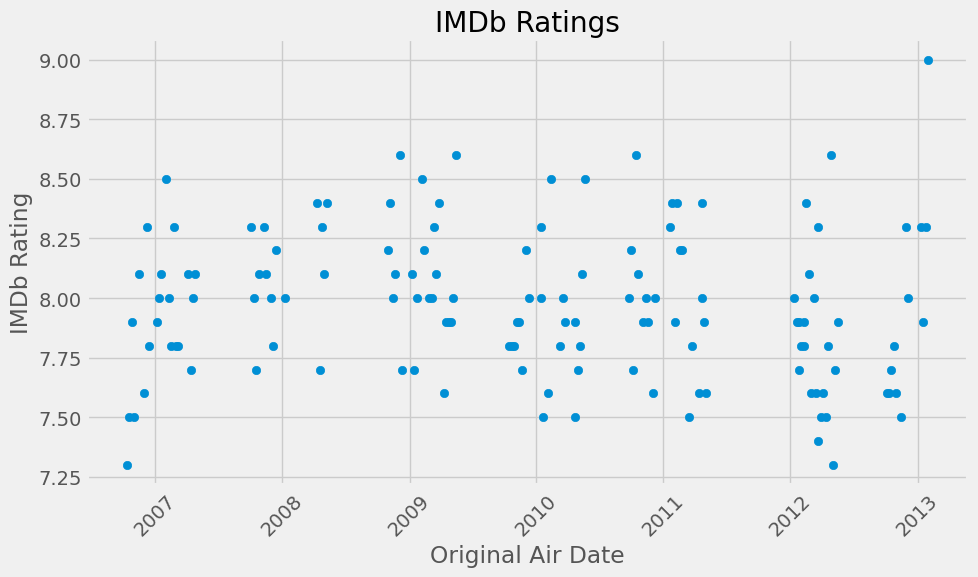

In [205]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(10, 6))
plt.scatter(df['original_air_date'], df['imdb_rating'])
plt.xlabel('Original Air Date')
plt.ylabel('IMDb Rating')
plt.title('IMDb Ratings')
plt.xticks(rotation=45)
plt.tight_layout()

The above plot looks pretty good with the default styling for 'fivethirtyeight'. It shows that the episodes have a wide range of IMDb ratings with the highest rating looking to be the last episode. The lowest rating seams to be either the first season or the sixth season. Let's take a look at some more details about those episodes. 

A data mask is used to filter the desired episodes into a new data frame. Then iterate over the data frame to print out the values. This reveals that the two episodes mentioned earlier as the possible lowest, were in fact rated both at 7.3. The highest rated was the final episode. 

In [209]:
# filter the highest and lowest rated episodes
# Create a data mask & min/max rating data frame
high_low_mask = (df['imdb_rating'] == max_rating) | (df['imdb_rating'] == min_rating)
high_low_df = df[high_low_mask]

# Print episode values
for episode in high_low_df.itertuples():
    f_string = f'Season: {episode.season}, Episode: {episode.episode_num}, IMDb Ratine: {episode.imdb_rating}'
    print(f_string)

Season: 1, Episode: 1, IMDb Ratine: 7.3
Season: 6, Episode: 20, IMDb Ratine: 7.3
Season: 7, Episode: 12, IMDb Ratine: 9.0


## Viewership Over Time
The next series of plots will show the viewership of 30 Rock over time. The initial plot is simple, but it has some issues as will soon be obvious. Unlike the ratings plot, which was a scatter plot, the gaps in time between air dates becomes a problem when visualized. There is nothing on the plot to indicate that there were no new episodes being aired at that time. This may cause some confusion for the person reading the plot. Since the purpose of visualizations is to bring clarity to the data, having the plot this way is not ideal. The issue will be addressed in the second iteration. Let's start with the simple plot.

Again using the 'fivethirtyeight' styling a slimple line plot is created. The x-axis will be the air dates and the y-axis will be viewers in millons. Listed below are some additions to make the plot more readable.
1. The viewership is scaled by dividing by `1e6`
2. The x-axis dates are formatted using the  `matplotlib.mdates` library
3. The major xticks are located using the `matplotlib.mdates` library

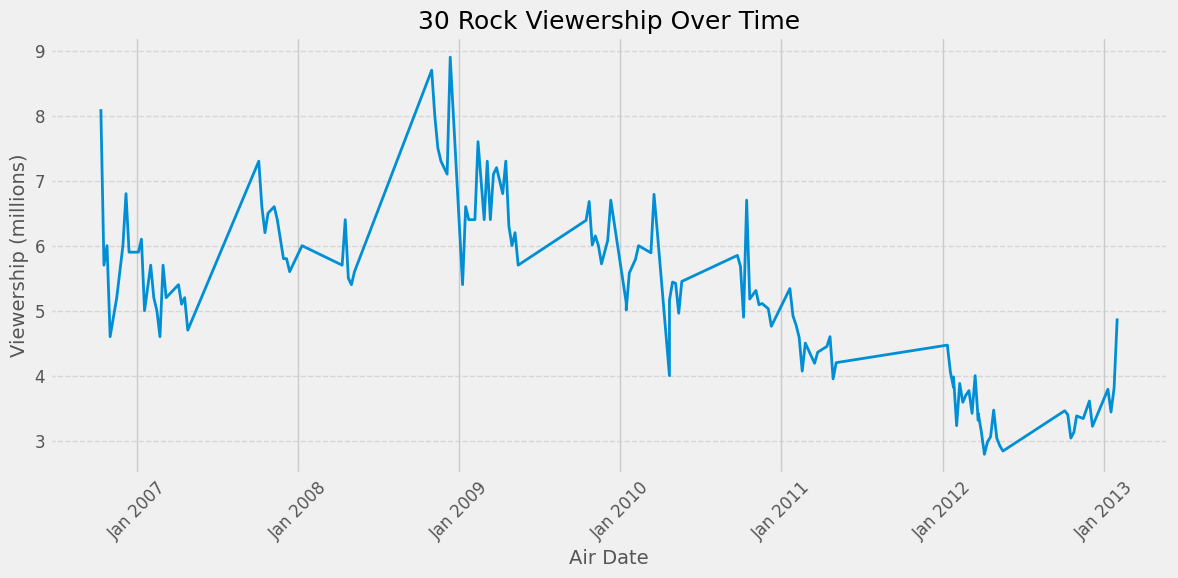

In [168]:
plt.style.use('fivethirtyeight')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the viewership data
ax.plot(df['original_air_date'], df['us_viewers'] / 1e6, linewidth=2)

# Set the title and labels
ax.set_title('30 Rock Viewership Over Time', fontsize=18)
ax.set_xlabel('Air Date', fontsize=14)
ax.set_ylabel('Viewership (millions)', fontsize=14)

# Format the x-axis tick labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45, fontsize=12)

# Format the y-axis tick labels
plt.yticks(fontsize=12)

# Add grid lines
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust the layout and display the plot
plt.tight_layout()

Now for some changes that will make the plot easier to understand. To address the disjointed look of the above plot, instead of the original air date, the x-axis will be the episode number. Since many of episode number are the same, the plot will have a separate line for each season. This will also require each line to have their own color.

Below is the code for the plot. The key difference between this plot and the one above is the for loop that plots each season on graph. First we get the unique values of the season column of the data frame. This will determine how many plots are created and their corrisponding colors. The 'plasma' color scheme is used by creating a varable `colors` by using the `matplotlib.colormaps` and indicating how many colors with the length of the `seasons`. A for loop is used with `enumerate(seasons)`, so that there is access to the index for the colors and the value for the season. Inside the for loop the following occurs:
1. Filter season data from data frame
2. assign a color to variable
3. create a plot with the episode number and the viewership, creating markers, and assigning a label for the legend

Finally, there is setting of all the labels, adding some grid style, and legend. With that this littel data analysis is finished.



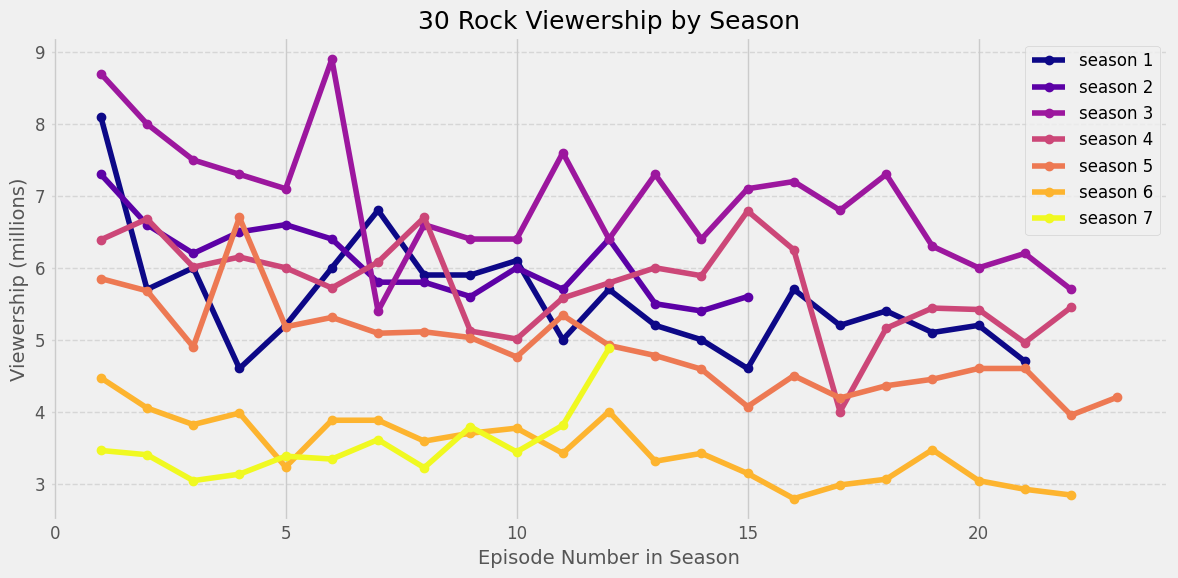

In [210]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(12,6))

seasons = df['season'].unique()

colors = plt.colormaps['plasma'].resampled(len(seasons))

for i, season in enumerate(seasons):
    season_data = df[df['season'] ==  season]
    color = colors(i)
    ax.plot(season_data['episode_num'],  season_data['us_viewers'] / 1e6, marker='o', label=f'season {season}', color=color)

# Set the title and labels
ax.set_title('30 Rock Viewership by Season', fontsize=18)
ax.set_xlabel('Episode Number in Season', fontsize=14)
ax.set_ylabel('Viewership (millions)', fontsize=14)

# Format the x-axis tick labels
plt.xticks(fontsize=12)

# Format the y-axis tick labels
plt.yticks(fontsize=12)

# Add grid lines
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend
ax.legend(fontsize=12)

# Adjust the layout and display the plot
plt.tight_layout()
    